# Stock Market Prediction Methods

The goal of the project is to use machine learning algorithms for stock market predictions.<br>
We are using stocks from Yahoo Finance for analysis.

In [1]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

### Web Scrapping
#### The historical data of the stock market is extracted using web scrapping method on Yahoo finance website. 
#### Using this method the historical data of any stock can be extracted for analysis

In [2]:
# Web scrapper function for yahoo finance 

import re
from io import StringIO
from datetime import datetime, timedelta

import requests
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

class YahooFinanceHistory:
    timeout = 2
    crumb_link = 'https://finance.yahoo.com/quote/{0}/history?p={0}'
    crumble_regex = r'CrumbStore":{"crumb":"(.*?)"}'
    quote_link = 'https://query1.finance.yahoo.com/v7/finance/download/{quote}?period1={dfrom}&period2={dto}&interval=1d&events=history&crumb={crumb}'

    def __init__(self, symbol, days_back=7):
        self.symbol = symbol
        self.session = requests.Session()
        self.dt = timedelta(days=days_back)

    def get_crumb(self):
        response = self.session.get(self.crumb_link.format(self.symbol), timeout=self.timeout)
        response.raise_for_status()
        match = re.search(self.crumble_regex, response.text)
        if not match:
            raise ValueError('Could not get crumb from Yahoo Finance')
        else:
            self.crumb = match.group(1)

    def get_quote(self):
        if not hasattr(self, 'crumb') or len(self.session.cookies) == 0:
            self.get_crumb()
        now = datetime.now()
        dateto = int(now.timestamp())
        datefrom = int((now - self.dt).timestamp())
        url = self.quote_link.format(quote=self.symbol, dfrom=datefrom, dto=dateto, crumb=self.crumb)
        response = self.session.get(url)
        response.raise_for_status()
        return pd.read_csv(StringIO(response.text), parse_dates=['Date'])

#### Use function YahooFinanaceHistory('Ticker_Name', days_back = Number of days in history)

We are selecting Morgan Stanley (MS) stock for analysis

In [3]:
# Use YahooFinanaceHistory('Ticker_Name', days_back = Number of days in history)
ticker = 'MS'
df = YahooFinanceHistory(ticker, days_back=4000).get_quote()
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2750,2019-11-22,48.939999,49.259998,48.820000,49.250000,49.250000,6609800
2751,2019-11-25,49.349998,49.980000,49.320000,49.959999,49.959999,8461000
2752,2019-11-26,49.919998,49.930000,49.070000,49.410000,49.410000,10360600
2753,2019-11-27,49.630001,49.869999,49.500000,49.779999,49.779999,8614000
2754,2019-11-29,49.700001,49.720001,49.369999,49.480000,49.480000,4138400


## Exploratory Data Analysis

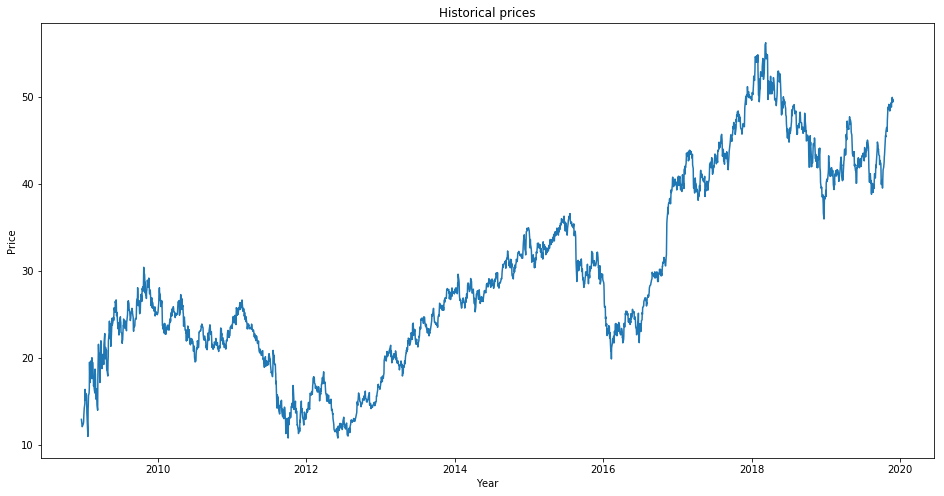

In [4]:
plt.figure(figsize=(16,8))
plt.title('Historical prices')
plt.xlabel('Year')
plt.ylabel('Price')
plt.plot(df['Date'], df['Adj Close'], label='Close Price history')
plt.show()

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-12-19,16.33,17.290001,15.45,15.45,12.912481,36407100
1,2008-12-22,15.62,15.630000,14.54,14.58,12.185370,19350500
2,2008-12-23,14.73,15.090000,14.40,14.44,12.068365,12686200
3,2008-12-24,14.25,14.750000,14.21,14.50,12.118510,5255100
4,2008-12-26,14.81,14.860000,14.35,14.65,12.243875,4467100


In [6]:
df.shape

(2755, 7)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2755 entries, 0 to 2754
Data columns (total 7 columns):
Date         2755 non-null datetime64[ns]
Open         2755 non-null float64
High         2755 non-null float64
Low          2755 non-null float64
Close        2755 non-null float64
Adj Close    2755 non-null float64
Volume       2755 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 150.7 KB


In [8]:
df.isna().values.any()

False

### Data Preprocessing

In [9]:
#sorting
data = df.sort_index(ascending=True, axis=0)

#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Adj Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Adj Close'][i] = data['Adj Close'][i]

data = data[['Date','Adj Close']]

Set up for train and test data. 80% train and 20% train

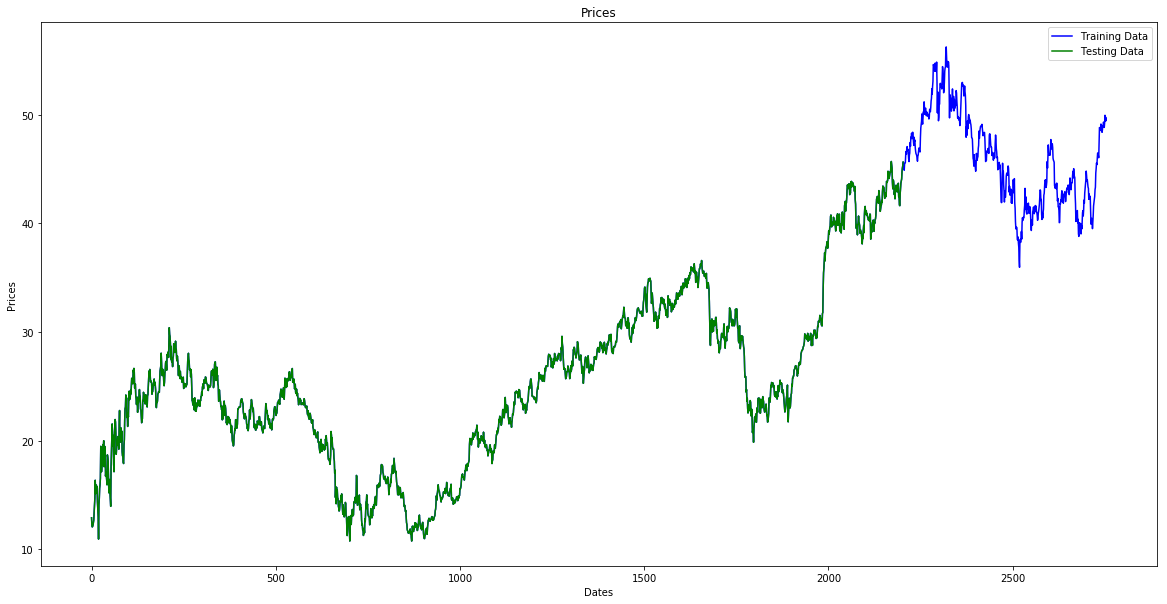

In [10]:
train, valid = data[0:int(len(data)*0.8)], data[int(len(data)*0.8):]
plt.figure(figsize=(20,10))
plt.title('Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(data['Adj Close'], 'blue', label='Training Data')
plt.plot(train['Adj Close'], 'green', label='Testing Data')
plt.legend()
plt.show()

In [11]:
x_train = np.array(train.index).reshape(-1, 1)
y_train = pd.DataFrame(train['Adj Close'])
x_valid = valid.drop('Adj Close', axis=1)
y_valid = np.array(valid['Adj Close']).reshape(-1,1)

## Linear Regression

Our data contains only one **independent variable (X)** which represents the **date** and the **dependent variable (Y)** we are trying to predict is the Stock Price. To fit a line to the data points, which then represents an estimated relationship between **X and Y**, we can use a Simple Linear Regression.

**The best fit line can be described with**

 **Y = 𝛽0 + 𝛽1 X**


where

$Y$ is the predicted value of the dependent variable

$\beta_0$ is the y-intercept

$\beta_1$ is the slope

$X$ is the value of the independent variable

The goal is to find such coefficients $\beta_0$ and $\beta_1$ that the Sum of Squared Errors, which represents the difference between each point in the dataset with it’s corresponding predicted value outputted by the model, is minimal.

Training a Linear Regression Model

#### Implement linear regression

In [12]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### Make predictions and find the rmse

In [13]:
preds = model.predict(y_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

29.42102509469585

#### Evaluation of the model by plotting predictions along with train and test data

c:\users\akshay gavandi\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\users\akshay gavandi\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


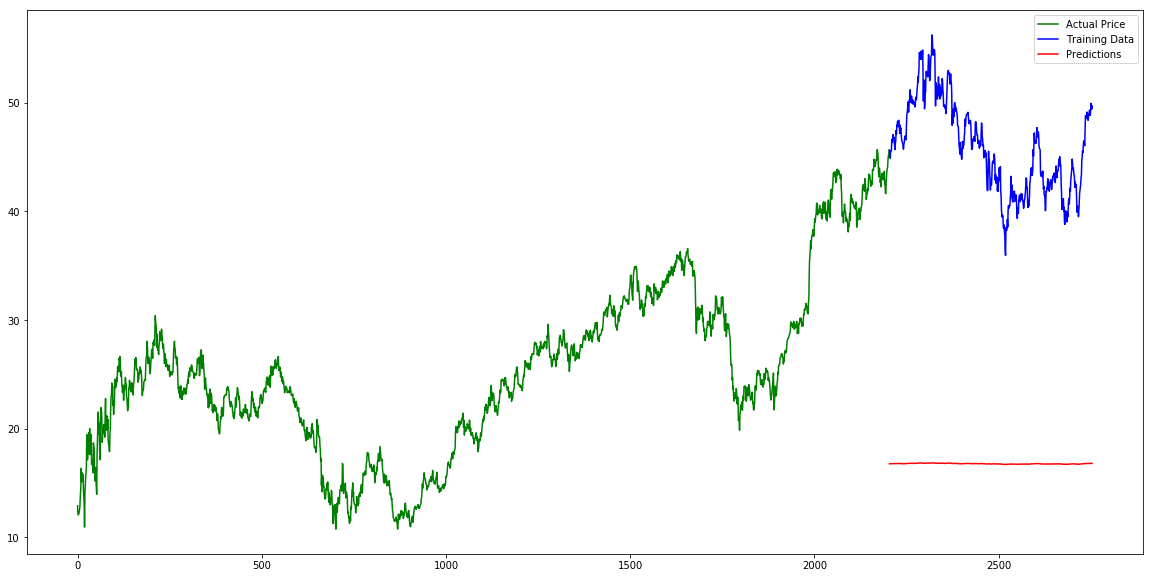

In [14]:
valid['Predictions'] = 0
valid['Predictions'] = preds
rcParams['figure.figsize'] = 20,10
valid.index = new_data[2204:].index
train.index = new_data[:2204].index
plt.plot(train['Adj Close'],  color='green',  label='Actual Price')
plt.plot(valid['Adj Close'],  color='blue', label='Training Data')
plt.plot(valid['Predictions'],  color='red', label='Predictions')
plt.legend()
plt.show()

The above plot shows that the linear regression has performed poorly for price prediction

#### Statistical evaluation of the model

In [15]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_valid, preds))  
print('Mean Squared Error:', metrics.mean_squared_error(y_valid, preds))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_valid, preds)))

Mean Absolute Error: 29.12349876737851
Mean Squared Error: 865.5967176227228
Root Mean Squared Error: 29.42102509469585


The above statistics show poor performance of the linear model

#### Practical evaluation of the model

In [16]:
data['Prediction'] = valid['Predictions']
predicted = data.dropna()

In [17]:
start_actual = predicted['Adj Close'].loc[2204]
start_predict = predicted['Prediction'].loc[2204]
today_actual = predicted['Adj Close'].loc[2754]
today_predicted = predicted['Prediction'].loc[2754]
print('Actual price: ', today_actual, 'Predicted Price:', today_predicted)

Actual price:  49.48 Predicted Price: 16.81187215809626


Conclusion: The linear model performs poorly for linear regression

### k Nearest Neighbours algorithm

The KNN algorithm assumes that similar things exist in close proximity. In other words, similar things are near to each other. <br><br>The KNN algorithm hinges on this assumption being true enough for the algorithm to be useful. KNN captures the idea of similarity (sometimes called distance, proximity, or closeness) with some mathematics we might have learned in our childhood— calculating the distance between points on a graph. To select the K that’s right for your data, we run the KNN algorithm several times with different values of K and choose the K that reduces the number of errors we encounter while maintaining the algorithm’s ability to accurately make predictions when it’s given data it hasn’t seen before.
#### Advantages
The algorithm is simple and easy to implement<br>
There’s no need to build a model, tune several parameters, or make additional assumptions<br>
The algorithm is versatile. It can be used for classification, regression, and search
#### Disadvantage
The algorithm gets significantly slower as the number of examples and/or predictors/independent variables increase.<br>


In [18]:
#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#### Building model 

In [19]:
#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)

c:\users\akshay gavandi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


#### Statistical evaluation of the model

In [20]:
#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

22.824454792175803

The statistical data is better than that of the linear model but not good enough for accurate predictions

#### Evaluation of the model by plotting predictions

c:\users\akshay gavandi\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\akshay gavandi\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


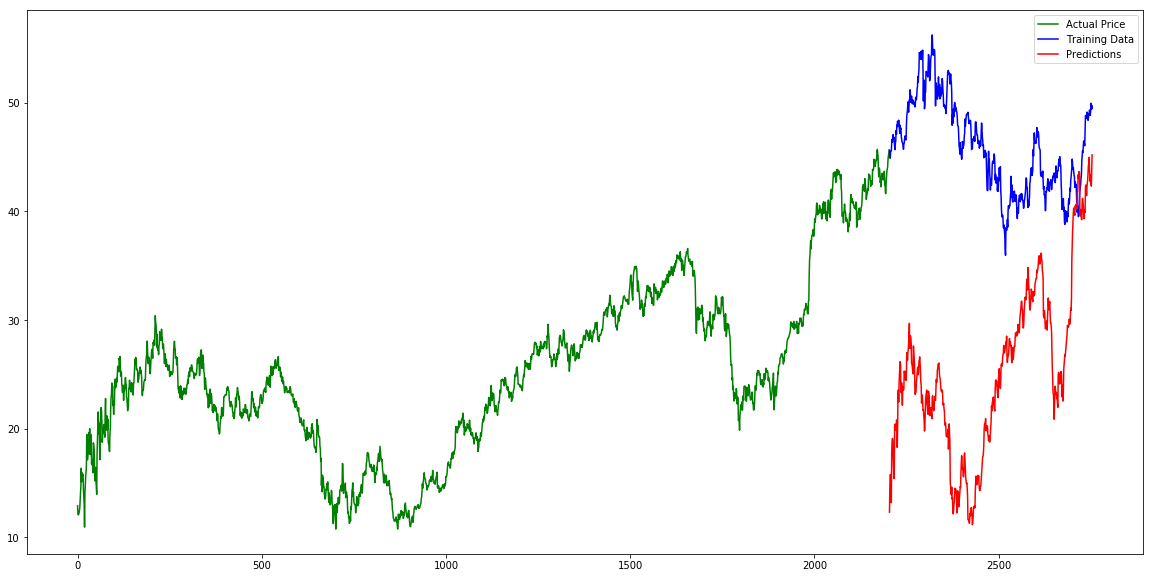

In [21]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['Adj Close'],  color='green',  label='Actual Price')
plt.plot(valid['Adj Close'],  color='blue', label='Training Data')
plt.plot(valid['Predictions'],  color='red', label='Predictions')
plt.legend()
plt.show()

The above plot shows the KNN model provides better results than linear model. The predictions nealy match the actual prices.

In [22]:
#### Practical evaluation of the model

In [23]:
data['Prediction'] = valid['Predictions']
predicted = data.dropna()

In [24]:
start_actual = predicted['Adj Close'].loc[2204]
start_predict = predicted['Prediction'].loc[2204]
today_actual = predicted['Adj Close'].loc[2754]
today_predicted = predicted['Prediction'].loc[2754]
print('Actual price: ', today_actual, 'Predicted Price:', today_predicted)

Actual price:  49.48 Predicted Price: 45.207737


The predicted price is nearly equal to actual price, but we cannot rely on this model for trading.

### Support Vector Machines 

Support Vector Machine is used to find a Hyperplane in an N Dimensional Space (where N is the number of features) that distinctly classifies the data points.<br>
Hyperplanes are decision boundaries that help classify the data points. Data points falling on either side of the hyperplane can be attributed to different classes.<br>
This can help us in building hyperplanes around the data points to decide if the stock prices are undervalued or overvalued and help us deciding whether to buy or sell.

#### Data Preprocessing

In [25]:
# Use YahooFinanaceHistory('Ticker_Name', days_back = Number of days in history)
ticker = 'MS'
df = YahooFinanceHistory(ticker, days_back=31).get_quote()

In [26]:
from sklearn.svm import SVR 

In [27]:
def get_data(df):  
    data = df.copy()
    data['Date'] = data['Date'].astype(str).str.split('-').str[2]
    data['Date'] = pd.to_numeric(data['Date'])
    return [ data['Date'].tolist(), data['Adj Close'].tolist() ] # Convert Series to list
dates, prices = get_data(df)

#### Building linear, polynomial and RBF kernels for SVM

In [28]:
# predict and plot function
def predict_prices(dates, prices, x):
    dates = np.reshape(dates,(len(dates), 1)) # convert to 1xn dimension
    x = np.reshape(x,(len(x), 1))
    
    svr_lin  = SVR(kernel='linear', C=1e3)
    svr_poly = SVR(kernel='poly', C=1e3, degree=2)
    svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
    
    # Fit regression model
    svr_lin .fit(dates, prices)
    svr_poly.fit(dates, prices)
    svr_rbf.fit(dates, prices)
    
    plt.scatter(dates, prices, c='k', label='Data')
    plt.plot(dates, svr_lin.predict(dates), c='g', label='Linear model')
    plt.plot(dates, svr_rbf.predict(dates), c='r', label='RBF model')    
    plt.plot(dates, svr_poly.predict(dates), c='b', label='Polynomial model')
    
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Support Vector Regression')
    plt.legend()
    plt.show()
    
    return svr_rbf.predict(x)[0], svr_lin.predict(x)[0], svr_poly.predict(x)[0]

#### Evaluation of the model by plotting hyperplanes around the data points

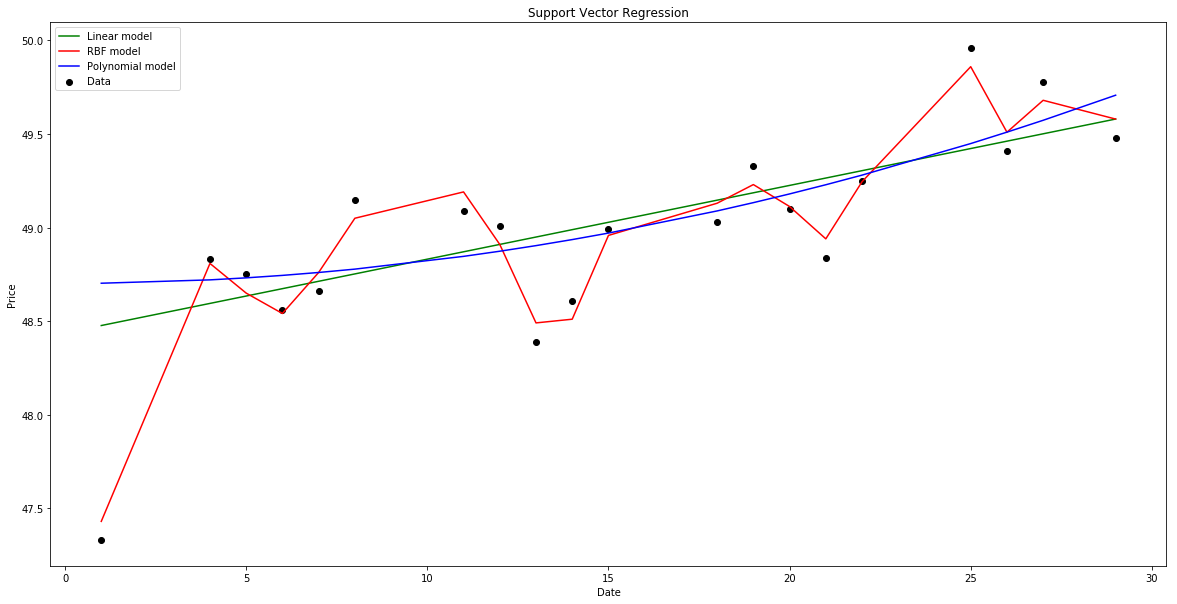

In [29]:
predicted_price = predict_prices(dates, prices, [31])

The above plot shows that the RBF model is better model than linear or polynomial to determine that the prices are overvalued or undervalued

### Stock Market Prediction using ARIMA

#### The goal is to find the price of the stock tomorrow using ARIMA model and the historical data of the stock market.

ARIMA stands for Auto Regressive Integrated Moving Average

#### Auto Regressive
The model that takes advantages of the connection between a predefined number of lagged observations and current one
#### Integrated
Difference between raw observations
#### Moving Average
The model that takes advantage of the relationship between residual error and the observations

The ARIMA model make use of these three parameters
p = number of lag observations
d = the degree of differencing
q = the size of the moving average window

ARIMA can lead to good results if applied to short time predictions. 

#### Data Preprocessing

In [30]:
data = YahooFinanceHistory('MS', days_back=4000).get_quote()
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2750,2019-11-22,48.939999,49.259998,48.820000,49.250000,49.250000,6609800
2751,2019-11-25,49.349998,49.980000,49.320000,49.959999,49.959999,8461000
2752,2019-11-26,49.919998,49.930000,49.070000,49.410000,49.410000,10360600
2753,2019-11-27,49.630001,49.869999,49.500000,49.779999,49.779999,8614000
2754,2019-11-29,49.700001,49.720001,49.369999,49.480000,49.480000,4138400


In [31]:
# Set datetime index for the stock data
data.set_index('Date', inplace = True)

In [32]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-12-19,16.33,17.290001,15.45,15.45,12.912481,36407100
2008-12-22,15.62,15.630000,14.54,14.58,12.185370,19350500
2008-12-23,14.73,15.090000,14.40,14.44,12.068365,12686200
2008-12-24,14.25,14.750000,14.21,14.50,12.118510,5255100
2008-12-26,14.81,14.860000,14.35,14.65,12.243875,4467100


#### Plot the training and test dataset for the selected stock
We will examine the adjusted close value as the end of day close price of the stock for analysis

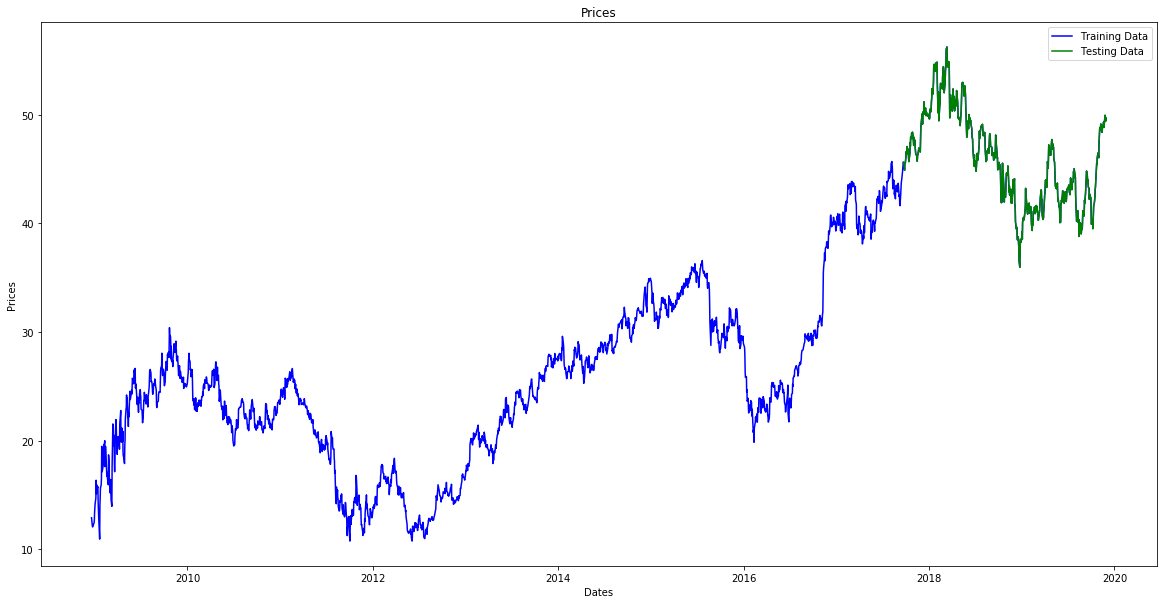

In [33]:
import matplotlib.pyplot as plt
train_data, test_data = data[0:int(len(data)*0.8)], data[int(len(data)*0.8):]
plt.figure(figsize=(20,10))
plt.title('Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(data['Adj Close'], 'blue', label='Training Data')
plt.plot(test_data['Adj Close'], 'green', label='Testing Data')
plt.legend()
plt.show()

Text(0.5,1,'Autocorrelation plot')

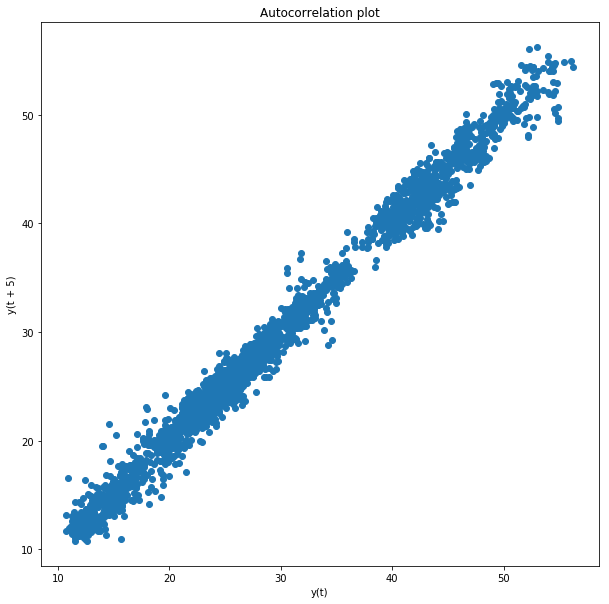

In [34]:
from pandas.plotting import lag_plot
plt.figure(figsize=(10,10))
lag_plot(data['Adj Close'], lag=5)
plt.title('Autocorrelation plot')

The results shown from the above plot show that ARIMA would be good model to be applied to this type of data

For model evaluation, we decide to use the Mean Squared Error(MSE) and Symmetric Mean Absolute Percentage Error.

Symmetric mean absolute percentage error (SMAPE or sMAPE) is an accuracy measure based on percentage (or relative) errors.

In [35]:
#Symmetric mean absolute percentage error used for relative errors
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

### Build ARIMA model using parameters:
Number of lag operations      (p) = 5 <br>
Degree of differencing        (d) = 1 <br>
Size of moving average window (q) = 0

In [36]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

train_ar = train_data['Adj Close'].values
test_ar = test_data['Adj Close'].values

history = [x for x in train_ar]
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 0.509
Symmetric mean absolute percentage error: 10.447


### Plot train, actual and predicted data to examine the efficiency of the model
It can be observed from the below plot that the predicted results are close to the actual data

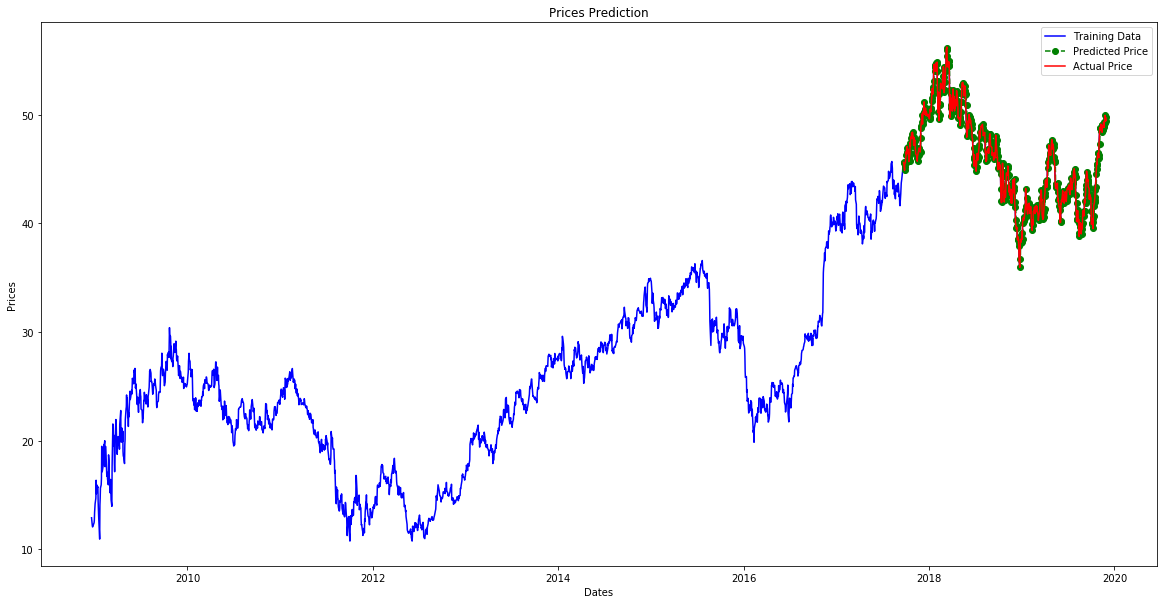

In [37]:
plt.figure(figsize=(20,10))
plt.plot(data['Adj Close'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Adj Close'], color='red', label='Actual Price')
plt.title('Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()
plt.show()

Create a dataframe to compare the actual and predicted data

In [38]:
predict = pd.DataFrame(predictions)
predict.set_index(test_data.index, inplace = True)
# predict.rename(columns={"0": "Adj Close"})
predict.head()

,0
Date,
2017-09-22,45.626861
2017-09-25,45.593982
2017-09-26,45.165282
2017-09-27,44.918850
2017-09-28,45.483094


#### Practical evaluation of the model

In [39]:
today_actual = data['Adj Close'].loc['2019-11-27']
today_predicted = predict[0].loc['2019-11-27']
print(today_actual, today_predicted)

49.779999 49.44444486784595


It can be obseved that the predicted and actual prices are almost the same.

### Actual and Predicted Comparison
We have build a model that predicts the value using lagged observation and moving averages. This means the predicted value is what the value should be as per the trained model and if the actual value is slightly offset that mean that next value is tend to converge towards the predicted value.<br>
We have tried to build a program that recommends when to buy, sell or hold stocks depending on these observations

In [40]:
data['Prediction'] = round(predict[0],2)
data['Adj Close'] = round(data['Adj Close'],2)

In [41]:
data[['Adj Close', 'Prediction']].tail()
data = data.dropna()

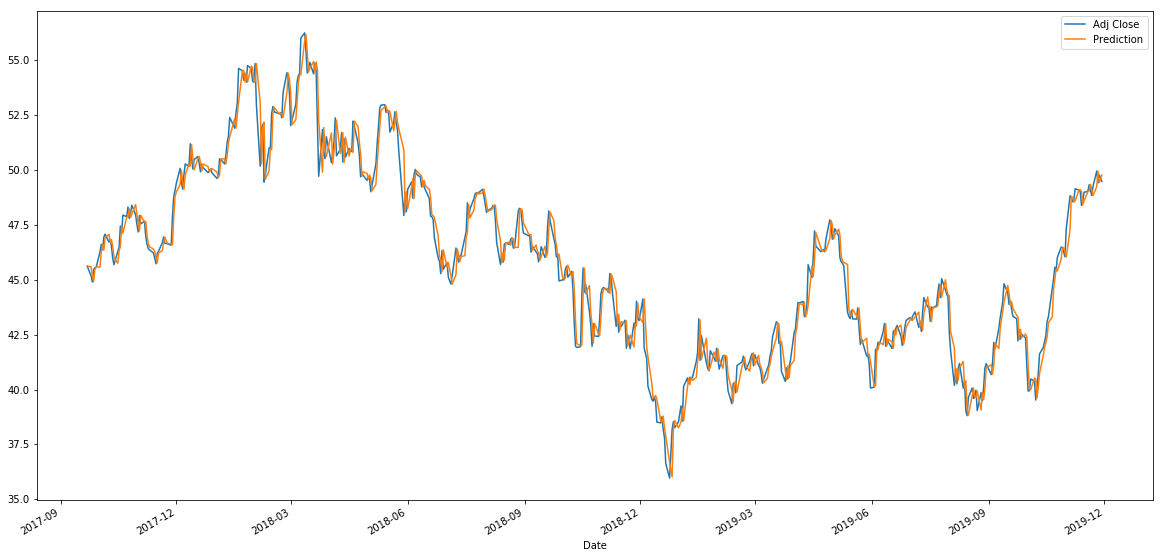

In [42]:
S1 = pd.Series(data['Adj Close'])
S2 = pd.Series(data['Prediction'])
pd.concat([S1,S2],axis=1).plot(figsize=(20,10))
plt.show()

#### Cointegration test for actual and predicted time series
Cointegration means the ratio between two series will vary around the mean.
Lets test the cointegration of the actual and predicted time series. If they are highly cointegrated, that means the ratio over time must converge to the mean.

In [43]:
from statsmodels.tsa.stattools import coint
score, pvalue, _ = coint(data['Adj Close'], data['Prediction'])
print('P Value', pvalue)

P Value 0.0


In [44]:
data['Adj Close'].corr(data['Prediction'])

0.9855958649572184

The above observations show the time series are highly cointegrated and correlated. This means when the time series drift towards or apart from each other, there will be times when the spread is high and times when spread is low.<br> 
Considering the actual time series should converge towards predicted, we buy stocks when predicted price is higher than actual since prices are supposed to rise. Similarly, we sell when actual price is lower than predited since prices are suppose to fall.

The ratio of the two time series show when the actual price of the stock is underpriced or overpriced. This way we buy the underpriced stocks and sell the overpriced ones. For convinience, we define z score of the ratios to recommend, when to trade.

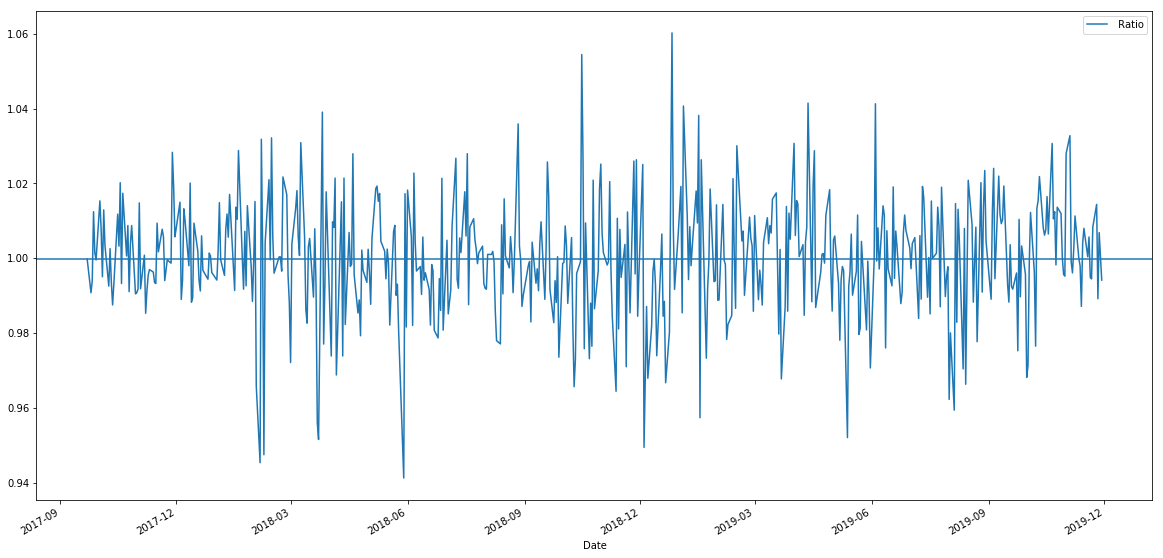

In [45]:
plt.figure(figsize=(20,10))

actual = data['Adj Close']
predicted = data['Prediction']
# score, pvalue, _ = coint(S1, S2)
# print(pvalue)
ratios = actual / predicted
ratios.plot()
plt.axhline(ratios.mean())
plt.legend([' Ratio'])
plt.show()

### Z Score
A Z-score is a numerical measurement used in statistics of a value's relationship to the mean (average) of a group of values, measured in terms of standard deviations from the mean. If a Z-score is 0, it indicates that the data point's score is identical to the mean score.

In [46]:
def zscore(series) :
    return (series - series.mean())/np.std(series)

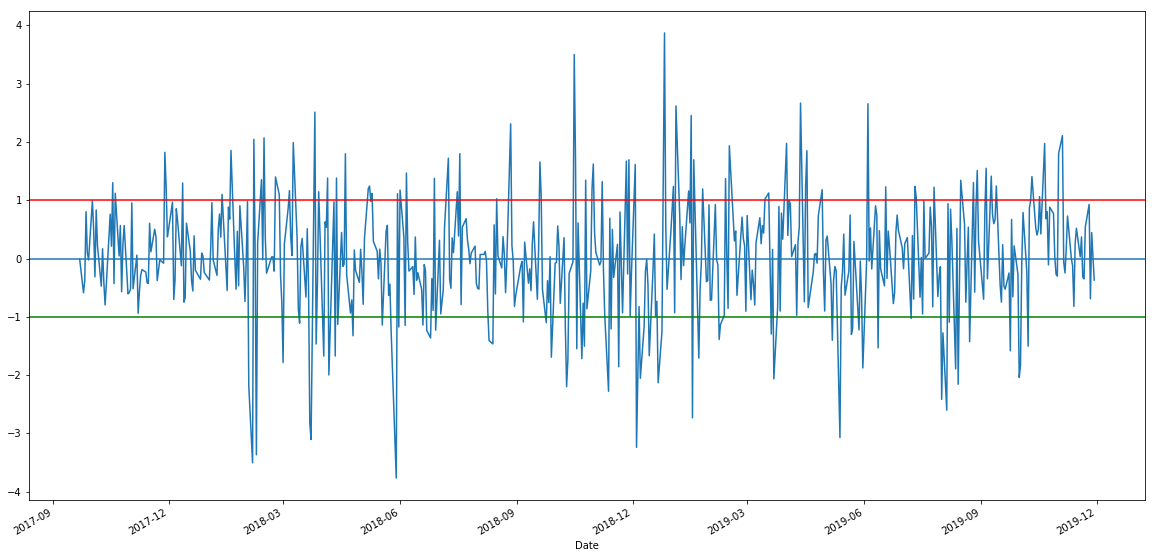

In [47]:
plt.figure(figsize=(20,10))

zscore(ratios).plot()
plt.axhline(zscore(ratios).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.show()

In [48]:
testZScores = pd.DataFrame()
testZScores['Z Score'] = zscore(ratios).dropna()
testZScores['Adj Close'] = data['Adj Close']
testZScores['Prediction'] = data['Prediction']

In [49]:
testZScores.head()

,Z Score,Adj Close,Prediction
Date,,,
2017-09-22,-0.010041,45.62,45.63
2017-09-25,-0.587172,45.17,45.59
2017-09-26,-0.379565,44.90,45.17
2017-09-27,0.804039,45.48,44.92
2017-09-28,0.102793,45.55,45.48


### When to Buy, Sell or Hold
Buy when stock is underpriced testZScores['Z Score'] <=-1.00 <br>
Sell when stock is overpriced testZScores['Z Score'] >= 1.00 <br>
Hold otherwise (testZScores['Z Score'] <  1.00) & (testZScores['Z Score'] > -1.00)

In [50]:
zthreshold = 0.2

In [51]:
testZScores['Action'] = np.where(testZScores['Z Score']<=-zthreshold, 
                                'Buy ',
                                 np.where(testZScores['Z Score']>=zthreshold, 
                                          'Sell',
                                          np.where((testZScores['Z Score'] <  zthreshold) & (testZScores['Z Score'] > -zthreshold),
                                                   'Hold',
                                                   'Invalid')))

In [52]:
actions = testZScores[['Adj Close', 'Action']]
actions.head()

,Adj Close,Action
Date,,
2017-09-22,45.62,Hold
2017-09-25,45.17,Buy
2017-09-26,44.90,Buy
2017-09-27,45.48,Sell
2017-09-28,45.55,Hold


In [53]:
#Buy and Sell Functions
def buy(money, current_price):
    no_of_shares = money//current_price
    investment = (current_price*no_of_shares)
    money = money - investment
    # print(money, no_of_shares, investment)
    return money, investment, no_of_shares, current_price

def sell(money, current_price, no_of_shares):
    investment = (current_price*no_of_shares)
    money = money + investment
    no_of_shares = 0
    # print(money, no_of_shares, investment)
    return money, investment, no_of_shares

### Trading Simulation
Let us simulate the trading using $1000 as the initial amount

In [54]:
#Trading Simulation  

money = 1000
total_investment = 0
no_of_shares = 0
isInvested = 0
current_investment = 0

print('Date', '               ', 'Action', '', 'Money', '', 'Current', '', 'Price')

for i in range(len(actions)):
    if actions['Action'][i] == 'Buy ' and isInvested == 0:
        print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
        if money>=actions['Adj Close'][i]:
            money, current_investment, no_of_shares, buy_price = buy(money, actions['Adj Close'][i])
            total_investment = total_investment + current_investment
            isInvested = 1            
    elif actions['Action'][i] == 'Sell':
        print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
        if total_investment>=actions['Adj Close'][i] and buy_price<actions['Adj Close'][i] and isInvested == 1:
            money, current_investment, no_of_shares = sell(money, actions['Adj Close'][i], no_of_shares)
            total_investment = 0
            isInvested = 0    
    else:
        print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))

print(round(money+total_investment),2)

Date                 Action  Money  Current  Price
2017-09-22 00:00:00   Hold   1000   0.0   45.62
2017-09-25 00:00:00   Buy    1000   0.0   45.17
2017-09-26 00:00:00   Buy    6.26   987.8   44.9
2017-09-27 00:00:00   Sell   6.26   1000.56   45.48
2017-09-28 00:00:00   Hold   1006.82   0.0   45.55
2017-09-29 00:00:00   Hold   1006.82   0.0   45.57
2017-10-02 00:00:00   Sell   1006.82   0.0   46.28
2017-10-03 00:00:00   Sell   1006.82   0.0   46.62
2017-10-04 00:00:00   Buy    1006.82   0.0   46.37
2017-10-05 00:00:00   Sell   33.05   985.95   46.95
2017-10-06 00:00:00   Sell   1019.0   0.0   47.08
2017-10-09 00:00:00   Buy    1019.0   0.0   46.72
2017-10-10 00:00:00   Hold   37.88   983.22   46.82
2017-10-11 00:00:00   Buy    37.88   977.13   46.53
2017-10-12 00:00:00   Buy    37.88   965.37   45.97
2017-10-13 00:00:00   Buy    37.88   959.49   45.69
2017-10-16 00:00:00   Sell   37.88   972.3   46.3
2017-10-17 00:00:00   Sell   37.88   975.87   46.47
2017-10-18 00:00:00   Sell   37.88 

2018-08-24 00:00:00   Hold   42.82   929.2   46.46
2018-08-27 00:00:00   Sell   42.82   963.0   48.15
2018-08-28 00:00:00   Sell   42.82   965.2   48.26
2018-08-29 00:00:00   Hold   42.82   964.2   48.21
2018-08-30 00:00:00   Buy    42.82   951.6   47.58
2018-08-31 00:00:00   Buy    42.82   942.6   47.13
2018-09-04 00:00:00   Hold   42.82   940.2   47.01
2018-09-05 00:00:00   Hold   42.82   940.4   47.02
2018-09-06 00:00:00   Buy    42.82   925.2   46.26
2018-09-07 00:00:00   Sell   42.82   930.8   46.54
2018-09-10 00:00:00   Buy    42.82   925.4   46.27
2018-09-11 00:00:00   Hold   42.82   923.8   46.19
2018-09-12 00:00:00   Buy    42.82   916.4   45.82
2018-09-13 00:00:00   Sell   42.82   921.2   46.06
2018-09-14 00:00:00   Sell   42.82   930.2   46.51
2018-09-17 00:00:00   Buy    42.82   920.4   46.02
2018-09-18 00:00:00   Hold   42.82   923.6   46.18
2018-09-19 00:00:00   Sell   42.82   947.8   47.39
2018-09-20 00:00:00   Sell   42.82   962.8   48.14
2018-09-21 00:00:00   Buy    42

2019-07-16 00:00:00   Hold   42.82   875.2   43.76
2019-07-17 00:00:00   Buy    42.82   862.2   43.11
2019-07-18 00:00:00   Sell   42.82   875.2   43.76
2019-07-19 00:00:00   Hold   42.82   874.4   43.72
2019-07-22 00:00:00   Hold   42.82   876.6   43.83
2019-07-23 00:00:00   Sell   42.82   888.4   44.42
2019-07-24 00:00:00   Sell   42.82   896.2   44.81
2019-07-25 00:00:00   Buy    42.82   883.8   44.19
2019-07-26 00:00:00   Sell   42.82   901.0   45.05
2019-07-29 00:00:00   Buy    42.82   890.8   44.54
2019-07-30 00:00:00   Buy    42.82   886.8   44.34
2019-07-31 00:00:00   Hold   42.82   884.6   44.23
2019-08-01 00:00:00   Buy    42.82   852.2   42.61
2019-08-02 00:00:00   Buy    42.82   836.2   41.81
2019-08-05 00:00:00   Buy    42.82   803.8   40.19
2019-08-06 00:00:00   Sell   42.82   818.2   40.91
2019-08-07 00:00:00   Buy    42.82   805.2   40.26
2019-08-08 00:00:00   Sell   42.82   819.2   40.96
2019-08-09 00:00:00   Sell   42.82   823.8   41.19
2019-08-12 00:00:00   Buy    42

The above recommendation log shows that \\$1000 invested on 2017-09-22 gives us \\$1151.02 as returns<br>
We bought 22 shares at price of \\$45.17 with remaining amount as \\$6.37<br>
If we had gone for a long term plan and removed the money at \\$49.48, the return would have been \\$1094.93<br>
This mean we have upped the profit by 50% and we can say our trading recommendation algorithm performed 50% better than the market

We can further improve the recommendations by using the optimal value of zthreshold. This can be found by find zthreshold that generates maximum returns in the investments

In [55]:
portfolios = pd.DataFrame()

for zthreshold in np.arange(0,2.00,0.05):
    testZScores['Action'] = np.where(testZScores['Z Score']<=-zthreshold, 
                                    'Buy ',
                                     np.where(testZScores['Z Score']>=zthreshold, 
                                              'Sell',
                                              np.where((testZScores['Z Score'] <  zthreshold) & (testZScores['Z Score'] > -zthreshold),
                                                       'Hold',
                                                       'Invalid')))
    actions = testZScores[['Adj Close', 'Action']]
    #Trading Simulation  

    money = 1000
    total_investment = 0
    no_of_shares = 0
    isInvested = 0
    current_investment = 0

    # print('Date', '               ', 'Action', '', 'Money', '', 'Current', '', 'Price')

    for i in range(len(actions)):
        if actions['Action'][i] == 'Buy ' and isInvested == 0:
    #         print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
            if money>=actions['Adj Close'][i]:
                money, current_investment, no_of_shares, buy_price = buy(money, actions['Adj Close'][i])
                total_investment = total_investment + current_investment
                isInvested = 1            
        elif actions['Action'][i] == 'Sell':
    #         print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
            if total_investment>=actions['Adj Close'][i] and buy_price<actions['Adj Close'][i] and isInvested == 1:
                money, current_investment, no_of_shares = sell(money, actions['Adj Close'][i], no_of_shares)
                total_investment = 0
                isInvested = 0    
    #     else:
    #         print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
    portfolios = portfolios.append({'zthreshold':'%.2f'%round(zthreshold,2), 'returns':round(money+total_investment,2)}, ignore_index=True)
#     print('%.2f'%round(zthreshold,2), round(money+total_investment,2))

    

In [56]:
portfolios[portfolios['returns']==portfolios['returns'].max()]

,returns,zthreshold
25,1340.52,1.25
26,1340.52,1.30


The above results show that the algorithm will generate maximum profits at zthreshold = 1.25 and 1.30

In [57]:
start_actual = data['Adj Close'].loc['2017-09-22']
start_predict = data['Prediction'].loc['2017-09-22']
today_actual = data['Adj Close'].loc['2019-11-27']
today_predicted = data['Prediction'].loc['2019-11-27']
print('Price on 2017-09-22: ', start_actual, 'Price on 2019-11-29: ',today_actual)
no_of_shares = 1000//start_actual
no_of_shares
remainder = 1000 - no_of_shares*start_actual
long_term_returns = round(no_of_shares*today_actual + remainder,2)
returns = portfolios[portfolios['returns']==portfolios['returns'].max()]
returns = returns[returns['zthreshold']==returns['zthreshold'].min()]
trading_return = float(returns['returns'].to_string(index = False))
print('Long term returns: ', long_term_returns)
print('Returns using algorithm: ', trading_return)
print('Percent return on long term investment: ', ((long_term_returns - 1000)/1000)*100, '%')
print('Percent return using trading algorithm: ', ((trading_return - 1000)/1000)*100, '%')

Price on 2017-09-22:  45.62 Price on 2019-11-29:  49.78
Long term returns:  1087.36
Returns using algorithm:  1340.52
Percent return on long term investment:  8.73599999999999 %
Percent return using trading algorithm:  34.052 %


A return on investment of \\$1340.52 is more than of what we get by long term investment<br>
Also the portfolio value increases by 34\% while the increase in stock value is 8.76\% over the 3 years of investment.

### Trading simulation results for different stocks

We will now try to simulate trading for different kind of stocks

#### Trading Apple Inc.(AAPL) 

In [58]:
data = YahooFinanceHistory('AAPL', days_back=4000).get_quote()
data.set_index('Date', inplace = True)
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

train_ar = train_data['Adj Close'].values
test_ar = test_data['Adj Close'].values

history = [x for x in train_ar]
# print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_ar, predictions)
# print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
# print('Symmetric mean absolute percentage error: %.3f' % error2)
predict = pd.DataFrame(predictions)
predict.set_index(test_data.index, inplace = True)
# predict.rename(columns={"0": "Adj Close"})
data['Prediction'] = predict[0]
data[['Adj Close', 'Prediction']].tail()
data = data.dropna()
plt.figure(figsize=(20,10))
testZScores = pd.DataFrame()
testZScores['Z Score'] = zscore(ratios).dropna()
testZScores['Adj Close'] = data['Adj Close']
testZScores['Prediction'] = data['Prediction']

portfolios = pd.DataFrame()

for zthreshold in np.arange(0,2.00,0.05):
    testZScores['Action'] = np.where(testZScores['Z Score']<=-zthreshold, 
                                    'Buy ',
                                     np.where(testZScores['Z Score']>=zthreshold, 
                                              'Sell',
                                              np.where((testZScores['Z Score'] <  zthreshold) & (testZScores['Z Score'] > -zthreshold),
                                                       'Hold',
                                                       'Invalid')))
    actions = testZScores[['Adj Close', 'Action']]
    #Trading Simulation  

    money = 1000
    total_investment = 0
    no_of_shares = 0
    isInvested = 0
    current_investment = 0

    # print('Date', '               ', 'Action', '', 'Money', '', 'Current', '', 'Price')

    for i in range(len(actions)):
        if actions['Action'][i] == 'Buy ' and isInvested == 0:
    #         print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
            if money>=actions['Adj Close'][i]:
                money, current_investment, no_of_shares, buy_price = buy(money, actions['Adj Close'][i])
                total_investment = total_investment + current_investment
                isInvested = 1            
        elif actions['Action'][i] == 'Sell':
    #         print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
            if total_investment>=actions['Adj Close'][i] and buy_price<actions['Adj Close'][i] and isInvested == 1:
                money, current_investment, no_of_shares = sell(money, actions['Adj Close'][i], no_of_shares)
                total_investment = 0
                isInvested = 0    
    #     else:
    #         print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
    portfolios = portfolios.append({'zthreshold':'%.2f'%round(zthreshold,2), 'returns':round(money+total_investment,2)}, ignore_index=True)
#     print('%.2f'%round(zthreshold,2), round(money+total_investment,2))
portfolios[portfolios['returns']==portfolios['returns'].max()]

,returns,zthreshold
36,1927.02,1.80
37,1927.02,1.85
38,1927.02,1.90
39,1927.02,1.95


<Figure size 1440x720 with 0 Axes>

In [59]:
start_actual = data['Adj Close'].loc['2017-09-22']
start_predict = data['Prediction'].loc['2017-09-22']
today_actual = data['Adj Close'].loc['2019-11-27']
today_predicted = data['Prediction'].loc['2019-11-27']
print('Price on 2017-09-22: ', start_actual, 'Price on 2019-11-29: ',today_actual)
no_of_shares = 1000//start_actual
no_of_shares
remainder = 1000 - no_of_shares*start_actual
long_term_returns = round(no_of_shares*today_actual + remainder,2)
returns = portfolios[portfolios['returns']==portfolios['returns'].max()]
returns = returns[returns['zthreshold']==returns['zthreshold'].min()]
trading_return = float(returns['returns'].to_string(index = False))
print('Long term returns: ', long_term_returns)
print('Returns using algorithm: ', trading_return)
print('Percent return on long term investment: ', ((long_term_returns - 1000)/1000)*100, '%')
print('Percent return using trading algorithm: ', ((trading_return - 1000)/1000)*100, '%')

Price on 2017-09-22:  146.900177 Price on 2019-11-29:  267.839996
Long term returns:  1725.64
Returns using algorithm:  1927.02
Percent return on long term investment:  72.56400000000001 %
Percent return using trading algorithm:  92.702 %


#### Trading Ford(F)

In [60]:
data = YahooFinanceHistory('F', days_back=4000).get_quote()
data.set_index('Date', inplace = True)
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

train_ar = train_data['Adj Close'].values
test_ar = test_data['Adj Close'].values

history = [x for x in train_ar]
# print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_squared_error(test_ar, predictions)
# print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
# print('Symmetric mean absolute percentage error: %.3f' % error2)
predict = pd.DataFrame(predictions)
predict.set_index(test_data.index, inplace = True)
# predict.rename(columns={"0": "Adj Close"})
data['Prediction'] = predict[0]
data[['Adj Close', 'Prediction']].tail()
data = data.dropna()
plt.figure(figsize=(20,10))
testZScores = pd.DataFrame()
testZScores['Z Score'] = zscore(ratios).dropna()
testZScores['Adj Close'] = data['Adj Close']
testZScores['Prediction'] = data['Prediction']

portfolios = pd.DataFrame()

for zthreshold in np.arange(0,2.00,0.05):
    testZScores['Action'] = np.where(testZScores['Z Score']<=-zthreshold, 
                                    'Buy ',
                                     np.where(testZScores['Z Score']>=zthreshold, 
                                              'Sell',
                                              np.where((testZScores['Z Score'] <  zthreshold) & (testZScores['Z Score'] > -zthreshold),
                                                       'Hold',
                                                       'Invalid')))
    actions = testZScores[['Adj Close', 'Action']]
    #Trading Simulation  

    money = 1000
    total_investment = 0
    no_of_shares = 0
    isInvested = 0
    current_investment = 0

    # print('Date', '               ', 'Action', '', 'Money', '', 'Current', '', 'Price')

    for i in range(len(actions)):
        if actions['Action'][i] == 'Buy ' and isInvested == 0:
    #         print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
            if money>=actions['Adj Close'][i]:
                money, current_investment, no_of_shares, buy_price = buy(money, actions['Adj Close'][i])
                total_investment = total_investment + current_investment
                isInvested = 1            
        elif actions['Action'][i] == 'Sell':
    #         print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
            if total_investment>=actions['Adj Close'][i] and buy_price<actions['Adj Close'][i] and isInvested == 1:
                money, current_investment, no_of_shares = sell(money, actions['Adj Close'][i], no_of_shares)
                total_investment = 0
                isInvested = 0    
    #     else:
    #         print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
    portfolios = portfolios.append({'zthreshold':'%.2f'%round(zthreshold,2), 'returns':round(money+total_investment,2)}, ignore_index=True)
#     print('%.2f'%round(zthreshold,2), round(money+total_investment,2))
portfolios[portfolios['returns']==portfolios['returns'].max()]

,returns,zthreshold
29,1369.6,1.45


<Figure size 1440x720 with 0 Axes>

In [61]:
start_actual = data['Adj Close'].loc['2017-09-22']
start_predict = data['Prediction'].loc['2017-09-22']
today_actual = data['Adj Close'].loc['2019-11-27']
today_predicted = data['Prediction'].loc['2019-11-27']
print('Price on 2017-09-22: ', start_actual, 'Price on 2019-11-29: ',today_actual)
no_of_shares = 1000//start_actual
no_of_shares
remainder = 1000 - no_of_shares*start_actual
long_term_returns = round(no_of_shares*today_actual + remainder,2)
returns = portfolios[portfolios['returns']==portfolios['returns'].max()]
trading_return = float(returns['returns'].to_string(index = False))
print('Long term returns: ', long_term_returns)
print('Returns using algorithm: ', trading_return)
print('Percent return on long term investment: ', ((long_term_returns - 1000)/1000)*100, '%')
print('Percent return using trading algorithm: ', ((trading_return - 1000)/1000)*100, '%')

Price on 2017-09-22:  10.231205000000001 Price on 2019-11-29:  9.1
Long term returns:  890.27
Returns using algorithm:  1369.6
Percent return on long term investment:  -10.973000000000003 %
Percent return using trading algorithm:  36.959999999999994 %


#### Trading General Motors(GM)

In [62]:
data = YahooFinanceHistory('GM', days_back=4000).get_quote()
data.set_index('Date', inplace = True)
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

train_ar = train_data['Adj Close'].values
test_ar = test_data['Adj Close'].values

history = [x for x in train_ar]
# print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_ar, predictions)
# print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
# print('Symmetric mean absolute percentage error: %.3f' % error2)
predict = pd.DataFrame(predictions)
predict.set_index(test_data.index, inplace = True)
# predict.rename(columns={"0": "Adj Close"})
data['Prediction'] = predict[0]
data[['Adj Close', 'Prediction']].tail()
data = data.dropna()
plt.figure(figsize=(20,10))
testZScores = pd.DataFrame()
testZScores['Z Score'] = zscore(ratios).dropna()
testZScores['Adj Close'] = data['Adj Close']
testZScores['Prediction'] = data['Prediction']

portfolios = pd.DataFrame()

for zthreshold in np.arange(0,2.00,0.05):
    testZScores['Action'] = np.where(testZScores['Z Score']<=-zthreshold, 
                                    'Buy ',
                                     np.where(testZScores['Z Score']>=zthreshold, 
                                              'Sell',
                                              np.where((testZScores['Z Score'] <  zthreshold) & (testZScores['Z Score'] > -zthreshold),
                                                       'Hold',
                                                       'Invalid')))
    actions = testZScores[['Adj Close', 'Action']]
    #Trading Simulation  

    money = 1000
    total_investment = 0
    no_of_shares = 0
    isInvested = 0
    current_investment = 0

    # print('Date', '               ', 'Action', '', 'Money', '', 'Current', '', 'Price')

    for i in range(len(actions)):
        if actions['Action'][i] == 'Buy ' and isInvested == 0:
    #         print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
            if money>=actions['Adj Close'][i]:
                money, current_investment, no_of_shares, buy_price = buy(money, actions['Adj Close'][i])
                total_investment = total_investment + current_investment
                isInvested = 1            
        elif actions['Action'][i] == 'Sell':
    #         print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
            if total_investment>=actions['Adj Close'][i] and buy_price<actions['Adj Close'][i] and isInvested == 1:
                money, current_investment, no_of_shares = sell(money, actions['Adj Close'][i], no_of_shares)
                total_investment = 0
                isInvested = 0    
    #     else:
    #         print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
    portfolios = portfolios.append({'zthreshold':'%.2f'%round(zthreshold,2), 'returns':round(money+total_investment,2)}, ignore_index=True)
#     print('%.2f'%round(zthreshold,2), round(money+total_investment,2))
portfolios[portfolios['returns']==portfolios['returns'].max()]

,returns,zthreshold
29,1805.0,1.45


<Figure size 1440x720 with 0 Axes>

In [63]:
start_actual = data['Adj Close'].loc['2017-09-22']
start_predict = data['Prediction'].loc['2017-09-22']
today_actual = data['Adj Close'].loc['2019-11-27']
today_predicted = data['Prediction'].loc['2019-11-27']
print('Price on 2017-09-22: ', start_actual, 'Price on 2019-11-29: ',today_actual)
no_of_shares = 1000//start_actual
no_of_shares
remainder = 1000 - no_of_shares*start_actual
long_term_returns = round(no_of_shares*today_actual + remainder,2)
returns = portfolios[portfolios['returns']==portfolios['returns'].max()]
trading_return = float(returns['returns'].to_string(index = False))
print('Long term returns: ', long_term_returns)
print('Returns using algorithm: ', trading_return)
print('Percent return on long term investment: ', ((long_term_returns - 1000)/1000)*100, '%')
print('Percent return using trading algorithm: ', ((trading_return - 1000)/1000)*100, '%')

Price on 2017-09-22:  36.401196 Price on 2019-11-29:  36.139998999999996
Long term returns:  992.95
Returns using algorithm:  1805.0
Percent return on long term investment:  -0.7049999999999955 %
Percent return using trading algorithm:  80.5 %


### Conclusion
We have implemented major machine learning algorithms for stock market predictions:<br>
 - Linear Regression<br>
 - k-nn Algorithm<br>
 - Support Vector Machines<br>
 - ARIMA model<br>

We have found ARIMA model as the best model for stock market predictions.<br>
We used ARIMA model prediction results for generating stock trading algorithm that recommends best time to buy and sell stocks to maximize the profits. The results have proven that the algorithm works better in providing results than going for long term investments.